In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [20]:

# Parameters
q = 50.0         # You can change this value if you want a different boundary slope
n_points = 1000  # Number of sample points in [0, 1]

# Grid
x = np.linspace(0.0, 1.0, n_points)

# Analytical solution coefficients
sinh = np.sinh
cosh = np.cosh
coth1 = cosh(1.0) / sinh(1.0)

# Solution and its derivative
y = q * (sinh(x) - cosh(x) * coth1)

# DataFrame
df = pd.DataFrame({
    "x": x,
    "y": y,
})
# pandas → numpy → torch
x_data = torch.tensor(df["x"].values, dtype=torch.float64).view(-1, 1)
y_data = torch.tensor(df["y"].values, dtype=torch.float64).view(-1, 1)


In [21]:
df

,x,y
0,0.000000,-65.651764
1,0.001001,-65.601747
2,0.002002,-65.551796
3,0.003003,-65.501910
4,0.004004,-65.452090
...,...,...
995,0.995996,-42.546247
996,0.996997,-42.546098
997,0.997998,-42.545992
998,0.998999,-42.545928


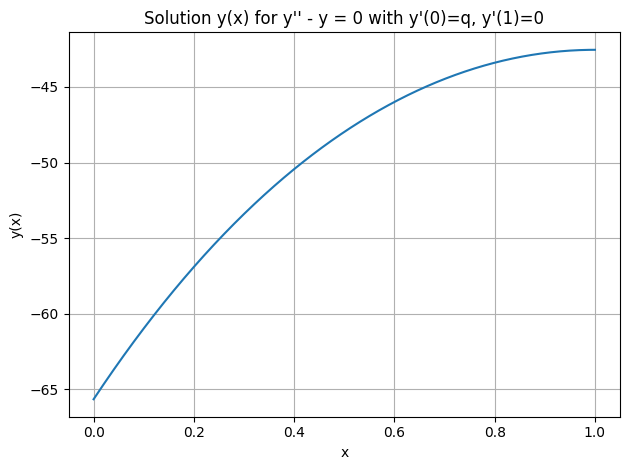

In [23]:
# Plot y(x)
plt.figure()
plt.plot(df["x"], df["y"])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("Solution y(x) for y'' - y = 0 with y'(0)=q, y'(1)=0")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(64, 64, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(64, 1, dtype=torch.float64)
        )
        self.q = nn.Parameter(torch.tensor(0, dtype=torch.float64))

    def forward(self, x):
        return self.net(x)      # giriş zaten double olmalı


In [25]:
def pinn_loss(model,
              x_colloc,
              x_data, y_data,
              lam_pde=1.0, lam_bc=10.0, lam_data=10.0):
    # ── PDE rezidüeli ───────────────────────────────────────────────
    x_colloc = x_colloc.detach().clone().requires_grad_(True)
    y        = model(x_colloc)
    dy_dx    = torch.autograd.grad(y, x_colloc, torch.ones_like(y),
                                   create_graph=True)[0]
    d2y_dx2  = torch.autograd.grad(dy_dx, x_colloc, torch.ones_like(dy_dx),
                                   create_graph=True)[0]
    loss_pde = ((d2y_dx2 - y) ** 2).mean()

    # ── Sınır koşulu ────────────────────────────────────────────────
    x0 = torch.zeros(1, 1, dtype=torch.float64, requires_grad=True)
    x1 = torch.ones (1, 1, dtype=torch.float64, requires_grad=True)
    y0_prime = torch.autograd.grad(model(x0), x0, torch.ones_like(x0),
                                   create_graph=True)[0]
    y1_prime = torch.autograd.grad(model(x1), x1, torch.ones_like(x1),
                                   create_graph=True)[0]
    loss_bc = (y0_prime - model.q)**2 + (y1_prime - 0.0)**2

    # ── DATA loss ──────────────────────────────────────────────────
    if x_data is not None and y_data is not None:
        y_hat = model(x_data)
        loss_data = ((y_hat - y_data) ** 2).mean()
    else:
        loss_data = torch.tensor(0.0, dtype=torch.float64)

    # ── Toplam ─────────────────────────────────────────────────────
    return (lam_pde * loss_pde
            + lam_bc   * loss_bc
            + lam_data * loss_data)


In [26]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for epoch in range(100000):
    optimizer.zero_grad()

    # Rastgele kolokasyon
    x_c = torch.rand(128, 1, dtype=torch.float64)

    # Loss: artık x_data, y_data da veriyoruz
    loss = pinn_loss(model, x_c, x_data,y_data,
                     lam_pde=10.0, lam_bc=1.0, lam_data=10.0)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f"ep {epoch+1:5d} | loss {loss.item():.2e} | q̂ {model.q.item():.4f}")


ep  1000 | loss 1.30e+04 | q̂ -0.0074
ep  2000 | loss 1.30e+04 | q̂ -0.0007
ep  3000 | loss 1.07e+04 | q̂ 0.8680
ep  4000 | loss 1.29e+03 | q̂ 3.0121
ep  5000 | loss 1.23e+03 | q̂ 4.1773
ep  6000 | loss 1.17e+03 | q̂ 5.2156
ep  7000 | loss 1.13e+03 | q̂ 6.2161
ep  8000 | loss 1.07e+03 | q̂ 7.2030
ep  9000 | loss 1.02e+03 | q̂ 8.1841
ep 10000 | loss 9.76e+02 | q̂ 9.1625
ep 11000 | loss 9.26e+02 | q̂ 10.1393
ep 12000 | loss 8.80e+02 | q̂ 11.1153
ep 13000 | loss 8.39e+02 | q̂ 12.0907
ep 14000 | loss 7.95e+02 | q̂ 13.0658
ep 15000 | loss 7.54e+02 | q̂ 14.0401
ep 16000 | loss 7.17e+02 | q̂ 15.0132
ep 17000 | loss 6.77e+02 | q̂ 15.9859
ep 18000 | loss 6.37e+02 | q̂ 16.9579
ep 19000 | loss 6.01e+02 | q̂ 17.9289
ep 20000 | loss 5.64e+02 | q̂ 18.8988
ep 21000 | loss 5.29e+02 | q̂ 19.8680
ep 22000 | loss 5.02e+02 | q̂ 20.8363
ep 23000 | loss 4.64e+02 | q̂ 21.8035
ep 24000 | loss 4.34e+02 | q̂ 22.7697
ep 25000 | loss 4.02e+02 | q̂ 23.7347
ep 26000 | loss 3.74e+02 | q̂ 24.6982
ep 27000 | loss 3.48

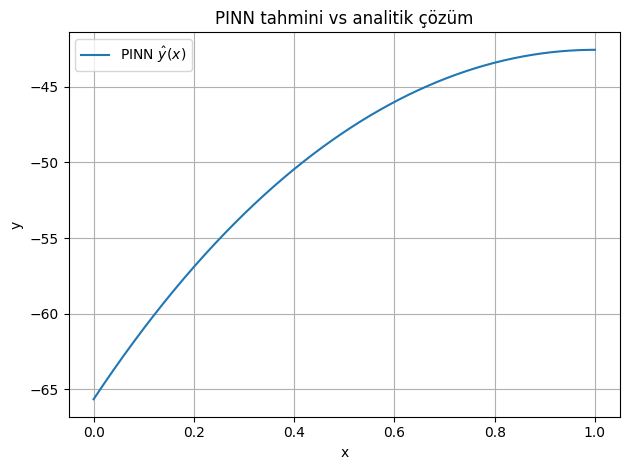

In [28]:

# ------------------------------------------------------------------
# 1) Çözümü ve (istersen) türevi için örnek x-ızgarası
# ------------------------------------------------------------------
x_grid = torch.linspace(0.0, 1.0, 1000, dtype=torch.float64).unsqueeze(1)

# ⇒ PINN çıktısı
with torch.no_grad():
    y_pred = model(x_grid).cpu().numpy().flatten()

# ------------------------------------------------------------------
# 2) Karşılaştırma için analitik çözüm (q = model.q veya sabit 1.0)
# ------------------------------------------------------------------
x_np   = x_grid.cpu().numpy()


# ------------------------------------------------------------------
# 3) Grafik
# ------------------------------------------------------------------
plt.figure()
plt.plot(x_np, y_pred, label="PINN $\\hat y(x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN tahmini vs analitik çözüm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
